<center>
    
    Machine Learning
    
    Author: Daniel Coble
</center>

In the last notebook, we wrote out the inference and training of an NN by hand. I think we can all agree that writing all of that out sucks a lot, and that it would be annoying to re-derive the backpropagation equations each time we change the shape of a model. Luckily, just like everything else we've implemented by hand, there's already a package for that. In fact, there are multiple. In this notebook, we'll use `tensorflow` and it's high-level, user-friendly interface `keras` (`pytorch` is another common ML package). Using a package means that we can use bigger data and bigger models. In short, we can start doing stuff that actually looks like machine learning. But the principle is still the same: just like in the last notebook, we have a dataset $\{x_i, y_i\}_{i=1}^N$, and want to develop a function $\phi$ which approximates $\phi(x_i)\approx y_i$. 

This notebook will go through a simple example of training an ML model using `keras`. Along the way, we'll discuss what's going on under-the-hood of the library, and best practices for creating ML models. 

Since this is supposed to be an introduction to machine learning for mechanical engineers, let's return again to the FEA beam that we used before. I've put the code to produce the dataset in fea.py so that we can load it here. `f` is the forcing function applied to the end of the beam, and you may find it interesting to mess around with changing `f`.

Resources:
[keras API](https://www.tensorflow.org/guide/keras)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fea import fea_beam

'''
forcing at the free end. Note that since 3*pi is irrational and 15 is rational, this forcing function is non-periodic.
'''
f = lambda t: .1*np.sin(3*np.pi/2*t) + .1*np.sin(15*t)

'''
parameters:
f: forcing function (maybe measured in kN)
t: total time (maybe measured in s)
returns:
W: displacement array with shape [timestep, node] (maybe measured in mm)
t: time array (maybe measured in s)
x: node points in the beam (maybe measured in m)
'''
(W, t, x) = fea_beam(f, t=50)

Let's make an animation of the beam vibration.

<IPython.core.display.Javascript object>


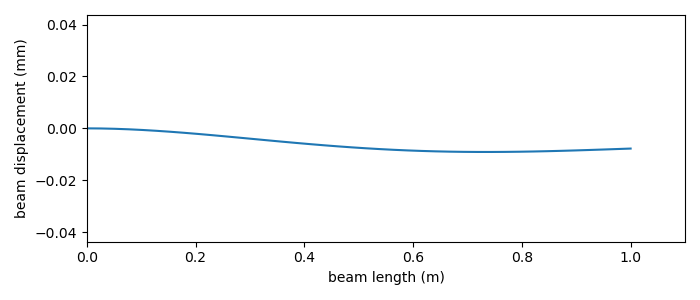

In [10]:
import matplotlib.animation
plt.ioff()
%matplotlib notebook
plt.rcParams["animation.html"] = "jshtml"

fig, ax = plt.subplots(figsize=(7, 3))
ax.set_xlim((0, 1.1*x[-1]))
max_displacement = np.max(np.abs(W))
ax.set_ylim((-1.1*max_displacement, 1.1*max_displacement))
ax.set_xlabel('beam length (m)')
ax.set_ylabel('beam displacement (mm)')
fig.tight_layout()
l, = ax.plot([],[])

def animate(i):
    l.set_data(x, W[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t.size, interval=(1/100)*1000)

Here's the problem we'll act like we're solving. Say that this beam represents an airplane wing and it's of interest to know what the deflection is at the very tip. However, it's impossible to measure deflection at the tip (perhaps we can't install a sensor there). We can put sensors up to half the length of the beam, and we want to use the data from those to guess at the deflection at the tip. In this scenario, imagine that the geometry is more complicated than just a beam, so that it would be impossible or impractical to create a closed-form solution to the problem. Therefore, we're resorting to ML to solve the problem.

In [56]:
from sklearn import model_selection

# for X data, use five node points from the first half of the beam
X = W[:,3:20:4]
x_node_points = x[3:20:4]
# for y data, use the end node point
y = W[:,-1].reshape(-1, 1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

Train the neural network.

In [71]:
import tensorflow as tf

model = keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

adam = keras.optimizers.Adam(learning_rate=.005)

model.compile(optimizer=adam, loss=tf.keras.losses.MeanSquaredError())

n_epochs = 50
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=64,
                    validation_data=(X_test, y_test)
)
y_pred = model.predict(X)

Epoch 1/50
250/250 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 1.1042e-04
Epoch 2/50
250/250 [==============================] - 0s 2ms/step - loss: 1.1114e-04 - val_loss: 1.1120e-04
Epoch 3/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0788e-04 - val_loss: 1.1779e-04
Epoch 4/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0758e-04 - val_loss: 1.0980e-04
Epoch 5/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0373e-04 - val_loss: 1.0594e-04
Epoch 6/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0736e-04 - val_loss: 1.1114e-04
Epoch 7/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0729e-04 - val_loss: 8.7153e-05
Epoch 8/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0385e-04 - val_loss: 9.9168e-05
Epoch 9/50
250/250 [==============================] - 0s 2ms/step - loss: 1.0498e-04 - val_loss: 1.0088e-04
Epoch 10/50
250/250 [===========

<IPython.core.display.Javascript object>


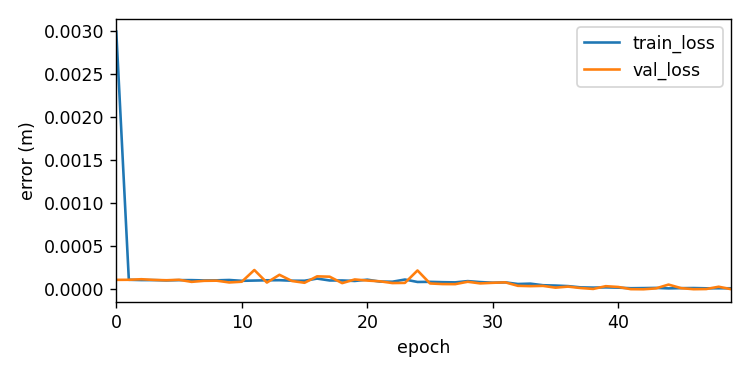

In [76]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

plt.figure(figsize=(6, 3))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlim((0, n_epochs-1))
plt.legend(loc=1)
plt.xlabel('epoch')
plt.ylabel('error (m)')
plt.tight_layout()

<IPython.core.display.Javascript object>


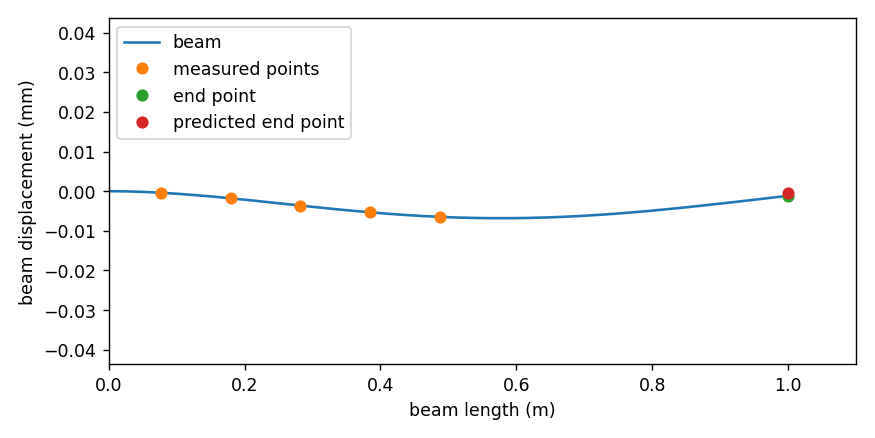

In [75]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.set_xlim((0, 1.1*x[-1]))
max_displacement = np.max(np.abs(W))
ax.set_ylim((-1.1*max_displacement, 1.1*max_displacement))
ax.set_xlabel('beam length (m)')
ax.set_ylabel('beam displacement (mm)')
l1, = ax.plot([],[], label='beam')
l2, = ax.plot([],[], marker='o', linewidth=0, label='measured points')
l3, = ax.plot([],[], marker='o', linewidth=0, label='end point')
l4, = ax.plot([],[], marker='o', linewidth=0, label='predicted end point')
ax.legend(loc=2)
fig.tight_layout()

def animate(i):
    l1.set_data(x, W[i])
    l2.set_data(x_node_points, X[i])
    l3.set_data([x[-1]], [y[i]])
    l4.set_data([x[-1]], [y_pred[i]])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t.size, interval=(1/100)*1000)